# Task
Train TinyBERT on a phishing/smishing dataset for binary classification (safe vs suspicious), evaluate its accuracy, and convert the trained model to a quantized .tflite model for Android on-device inference.

## Setup environment

### Subtask:
Install necessary libraries (transformers, datasets, tensorflow).


**Reasoning**:
Install the necessary libraries using pip.



In [1]:
%pip install transformers datasets tensorflow

## Load dataset

### Subtask:
Fetch a suitable dataset for phishing/smishing messages with 'message' and 'label' columns (0 for safe, 1 for suspicious). Load the dataset into a pandas DataFrame or Hugging Face Dataset object.


**Reasoning**:
Import the necessary function and load the dataset using the `load_dataset` function.



In [4]:
from datasets import load_dataset
import pandas as pd

# Attempt to load a suitable dataset. 'sms_spam' is a common dataset for SMS,
# but we need a dataset with broader phishing/scam messages beyond just SMS.
# Searching for datasets on Hugging Face Hub related to "phishing", "scam", "malicious text".
# For demonstration, we will still start with 'sms_spam' as a common example,
# but acknowledge the need for a more comprehensive dataset for a real-world application.
# A more robust solution would involve finding and potentially combining multiple datasets.

try:
    # Let's start with sms_spam as it's readily available, but note its limitation to SMS.
    dataset = load_dataset("sms_spam")
    # Rename columns to 'message' and 'label' if they are 'sms' and 'label'
    if 'sms' in dataset['train'].column_names and 'label' in dataset['train'].column_names:
        dataset = dataset.rename_columns({"sms": "message"})
    print("Loaded 'sms_spam' dataset. Note: This dataset is primarily SMS spam.")
    print("For a real-world application scanning notifications, a dataset with broader phishing/scam examples would be necessary.")

except Exception as e:
    print(f"Could not load 'sms_spam' dataset: {e}")
    # Placeholder for attempting to load a more comprehensive dataset
    try:
        print("Attempting to load a potentially broader dataset (placeholder)...")
        # In a real scenario, you would replace this with code to load a suitable dataset
        # For example: dataset = load_dataset("user/dataset_with_phishing_scam_messages")
        # For this example, we will proceed with sms_spam if it loaded, or fail if not.
        raise Exception("No suitable alternative dataset found or implemented in this example.")
    except Exception as e_alt:
        print(f"Could not load an alternative dataset: {e_alt}")
        dataset = None # Ensure dataset is None if loading fails

if dataset:
    print("Dataset loaded successfully.")
    print(dataset)
    # Display the first few examples to understand the data format
    if 'train' in dataset:
        print("First 5 examples from the training set:")
        print(dataset['train'].select(range(5)))
else:
    print("Failed to load a suitable dataset.")

Loaded 'sms_spam' dataset. Note: This dataset is primarily SMS spam.
For a real-world application scanning notifications, a dataset with broader phishing/scam examples would be necessary.
Dataset loaded successfully.
DatasetDict({
    train: Dataset({
        features: ['message', 'label'],
        num_rows: 5574
    })
})
First 5 examples from the training set:
Dataset({
    features: ['message', 'label'],
    num_rows: 5
})


## Load tinybert model and tokenizer

### Subtask:
Load the pre-trained TinyBERT model ("huawei-noah/TinyBERT_General_4L_312D") and its corresponding tokenizer from Hugging Face.


**Reasoning**:
The subtask requires loading the pre-trained TinyBERT model and tokenizer from Hugging Face. I need to import the necessary classes from the `transformers` library and then use the `from_pretrained` method to load the model and tokenizer.



**Reasoning**:
The previous command failed because `TFTinyBERTForSequenceClassification` could not be imported. Based on the Hugging Face documentation and common practices, the correct class for TensorFlow TinyBERT for sequence classification is likely `TFTinyBertForSequenceClassification` (with a lowercase 'b'). I will correct the import statement and retry loading the model and tokenizer.



In [9]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer

# Load the pre-trained TinyBERT tokenizer using AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")

# Load the pre-trained TinyBERT model for sequence classification using TFAutoModelForSequenceClassification
# This class can load the appropriate model based on the provided model name.
# Add from_pt=True to load from PyTorch weights
try:
    model = TFAutoModelForSequenceClassification.from_pretrained("huawei-noah/TinyBERT_General_4L_312D", num_labels=2, from_pt=True)
    print("\nTinyBERT model loaded successfully using TFAutoModelForSequenceClassification and PyTorch weights.")
except Exception as e:
    print(f"\nFailed to load TinyBERT model using TFAutoModelForSequenceClassification: {e}")
    print("It's possible the model name 'huawei-noah/TinyBERT_General_4L_312D' is not directly supported by TFAutoModelForSequenceClassification for sequence classification, or there's another configuration issue.")


print("\nAttempting to import TFTinyBertForSequenceClassification again (might be an alias or specific import path):")
try:
    from transformers import TFTinyBertForSequenceClassification
    print("Import successful!")
except ImportError:
    print("TFTinyBertForSequenceClassification still not found directly.")

pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['fit_denses.1.bias', 'fit_denses.4.bias', 'fit_denses.2.bias', 'fit_denses.4.weight', 'fit_denses.2.weight', 'fit_denses.0.weight', 'fit_denses.0.bias', 'fit_denses.1.weight', 'fit_denses.3.bias', 'fit_denses.3.weight']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights


TinyBERT model loaded successfully using TFAutoModelForSequenceClassification and PyTorch weights.

Attempting to import TFTinyBertForSequenceClassification again (might be an alias or specific import path):
TFTinyBertForSequenceClassification still not found directly.


## Preprocess Data

### Subtask:
Tokenize the 'message' column using the loaded tokenizer. Split the dataset into training and testing sets.

**Reasoning**:
Tokenize the text data using the loaded TinyBERT tokenizer. The tokenizer will convert the text messages into numerical input IDs, attention masks, and token type IDs that the model can understand. After tokenization, split the dataset into training and testing sets to prepare for model training and evaluation.

In [10]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Tokenize the dataset
def tokenize_function(examples):
    # Use truncation and padding to handle varying message lengths
    return tokenizer(examples["message"], padding="max_length", truncation=True, max_length=128) # Increased max_length

# Apply tokenization to the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Convert to TensorFlow datasets
# Remove the original 'message' column as it's no longer needed after tokenization
tokenized_datasets = tokenized_datasets.remove_columns(["message"])
# Rename the 'label' column to 'labels' to match the expected input name for the model
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

# Split the dataset into training and testing sets
# Use the existing split if available (like in sms_spam), otherwise perform a split
if 'train' in tokenized_datasets and 'test' in tokenized_datasets:
    train_dataset = tokenized_datasets['train']
    test_dataset = tokenized_datasets['test']
    print("Using existing train/test split.")
elif 'train' in tokenized_datasets:
    # If only a 'train' split exists, split it into train and test
    train_test_split_dataset = tokenized_datasets['train'].train_test_split(test_size=0.2)
    train_dataset = train_test_split_dataset['train']
    test_dataset = train_test_split_dataset['test']
    print("Created train/test split from the available data.")
else:
    raise Exception("Dataset does not have a recognizable split for training and testing.")


# Prepare the datasets for TensorFlow
# Convert to TensorFlow format, specifying the columns the model expects
train_dataset = train_dataset.to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    label_cols=['labels'],
    batch_size=16,
    shuffle=True
)

test_dataset = test_dataset.to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    label_cols=['labels'],
    batch_size=16,
    shuffle=False # No need to shuffle test data
)

print("\nData preprocessing complete.")
print("Training dataset:", train_dataset)
print("Testing dataset:", test_dataset)

Map:   0%|          | 0/5574 [00:00<?, ? examples/s]

Created train/test split from the available data.


/usr/local/lib/python3.11/dist-packages/datasets/arrow_dataset.py:403: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(



Data preprocessing complete.
Training dataset: <_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 128), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 128), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
Testing dataset: <_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 128), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 128), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


## Build and Compile Model

### Subtask:
Build a TensorFlow model for binary classification on top of the TinyBERT model. Compile the model with the Adam optimizer, SparseCategoricalCrossentropy loss, and accuracy metric.

**Reasoning**:
Use the loaded `TFAutoModelForSequenceClassification` as the base and compile it for the binary classification task. Define the optimizer, loss function suitable for binary classification, and the metric to track during training.

In [11]:
import tensorflow as tf

# The loaded model is already configured for sequence classification with 2 labels.
# We can directly compile this model.

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

# Define the loss function. Use SparseCategoricalCrossentropy for integer labels.
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Define the metrics
metrics = ['accuracy']

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

print("Model built and compiled successfully.")

Model built and compiled successfully.


## Train Model

### Subtask:
Train the model on the training data for 5 epochs with a batch size of 16.

**Reasoning**:
Train the compiled model using the `fit` method, providing the training dataset, the number of epochs, and the batch size.

In [12]:
print("Starting model training...")

# Train the model
history = model.fit(
    train_dataset,
    epochs=5
)

print("Model training complete.")

Starting model training...
Epoch 1/5
279/279 [==============================] - 604s 2s/step - loss: 0.1476 - accuracy: 0.9596
Epoch 2/5
279/279 [==============================] - 567s 2s/step - loss: 0.0479 - accuracy: 0.9872
Epoch 3/5
279/279 [==============================] - 554s 2s/step - loss: 0.0266 - accuracy: 0.9930
Epoch 4/5
279/279 [==============================] - 561s 2s/step - loss: 0.0153 - accuracy: 0.9964
Epoch 5/5
279/279 [==============================] - 568s 2s/step - loss: 0.0068 - accuracy: 0.9980
Model training complete.


## Evaluate Model

### Subtask:
Evaluate the trained model on the testing data to assess its accuracy.

**Reasoning**:
Evaluate the trained model on the test dataset using the `evaluate` method to get the loss and accuracy.

In [14]:
print("Evaluating model on the test dataset...")

# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_dataset)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Evaluating model on the test dataset...
70/70 [==============================] - 68s 938ms/step - loss: 0.0422 - accuracy: 0.9928

Test Loss: 0.0422
Test Accuracy: 0.9928


## Save Model

### Subtask:
Save the trained model in the TensorFlow SavedModel format.

**Reasoning**:
Save the trained model using the `save` method in the SavedModel format.

In [15]:
import os

# Define the directory to save the model
saved_model_dir = './tinybert_saved_model'

# Save the model in the SavedModel format
model.save(saved_model_dir, save_format='tf')

print(f"Model saved to {saved_model_dir}")

Model saved to ./tinybert_saved_model


## Convert to TFLite

### Subtask:
Convert the SavedModel to TensorFlow Lite format with optimizations for mobile deployment.

**Reasoning**:
Load the saved TensorFlow model and use the TFLiteConverter to convert it to a TFLite model. Apply optimizations for size and performance suitable for mobile devices.

In [17]:
import tensorflow as tf

# Load the saved TensorFlow model
saved_model_dir = './tinybert_saved_model'
loaded_model = tf.saved_model.load(saved_model_dir)

# Define the concrete function for the model
# This is necessary for the TFLiteConverter
# concrete_func = loaded_model.signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY] # This line is not needed for the converter

# Instantiate the TFLite converter
# Remove the signature_key argument
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)

# Apply optimizations for mobile deployment
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_model = converter.convert()

# Define the output path for the TFLite model
tflite_model_path = './tinybert_quantized.tflite'

# Save the TFLite model
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"TensorFlow Lite model saved to {tflite_model_path}")

TensorFlow Lite model saved to ./tinybert_quantized.tflite


## Download TFLite Model

### Subtask:
Download the generated `.tflite` model file.

**Reasoning**:
Provide code to download the saved TFLite model file directly from the Colab environment.

In [18]:
from google.colab import files

# Define the path to the TFLite model file
tflite_model_path = './tinybert_quantized.tflite'

# Download the file
try:
  files.download(tflite_model_path)
  print(f"\nDownloading {tflite_model_path}...")
except FileNotFoundError:
  print(f"\nError: {tflite_model_path} not found. Please ensure the conversion step was successful.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Download SavedModel Directory

### Subtask:
Download the entire SavedModel directory.

**Reasoning**:
Use a utility function to create a zip archive of the saved model directory and then provide code to download the zip file.

In [19]:
import shutil
import os
from google.colab import files

# Define the directory to be zipped and the output zip file name
saved_model_dir = './tinybert_saved_model'
zip_filename = 'tinybert_saved_model.zip'

# Create a zip archive of the directory
shutil.make_archive(zip_filename.replace('.zip', ''), 'zip', saved_model_dir)

print(f"Created zip archive: {zip_filename}")

# Download the zip file
try:
  files.download(zip_filename)
  print(f"\nDownloading {zip_filename}...")
except FileNotFoundError:
  print(f"\nError: {zip_filename} not found. Please ensure the zipping step was successful.")

Created zip archive: tinybert_saved_model.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Demonstrate Test Cases

### Subtask:
Use the trained model to make predictions on a few sample messages and display the results.

**Reasoning**:
Select a few examples from the test dataset or create new sample messages. Tokenize these messages and use the trained model to predict their labels. Display the original message, the predicted label, and the true label (if available).

In [20]:
import tensorflow as tf
import numpy as np

# Define some sample messages to test
test_messages = [
    "Congratulations! You've won a free iPhone. Click here to claim.", # Suspicious
    "Meeting scheduled for tomorrow at 10 AM.", # Safe
    "Your account has been compromised. Verify your details immediately.", # Suspicious
    "Did you receive the document I sent?", # Safe
    "Urgent: Your package is waiting for delivery. Please confirm your address.", # Suspicious
]

# Tokenize the test messages
# Use the same tokenizer and padding/truncation settings as during training
tokenized_test_messages = tokenizer(
    test_messages,
    padding="max_length",
    truncation=True,
    max_length=128,
    return_tensors="tf" # Return TensorFlow tensors
)

# Make predictions using the trained model
predictions = model.predict(
    {'input_ids': tokenized_test_messages['input_ids'],
     'attention_mask': tokenized_test_messages['attention_mask']}
)

# Get the predicted labels (0 for safe, 1 for suspicious)
# The model outputs logits, so apply argmax to get the predicted class index
predicted_labels = np.argmax(predictions.logits, axis=1)

# Map labels to readable strings
label_map = {0: "Safe", 1: "Suspicious"}
predicted_label_strings = [label_map[label] for label in predicted_labels]

print("Test Case Predictions:")
for i, message in enumerate(test_messages):
    print(f"Message: {message}")
    print(f"Predicted Label: {predicted_label_strings[i]}")
    # If you have true labels for these messages, you can add them here for comparison
    print("-" * 30)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


1/1 [==============================] - 1s 1s/step
Test Case Predictions:
Message: Congratulations! You've won a free iPhone. Click here to claim.
Predicted Label: Suspicious
------------------------------
Message: Meeting scheduled for tomorrow at 10 AM.
Predicted Label: Safe
------------------------------
Message: Your account has been compromised. Verify your details immediately.
Predicted Label: Safe
------------------------------
Message: Did you receive the document I sent?
Predicted Label: Safe
------------------------------
Message: Urgent: Your package is waiting for delivery. Please confirm your address.
Predicted Label: Safe
------------------------------


## Visualize Training Accuracy

### Subtask:
Plot the training accuracy over epochs.

**Reasoning**:
Use the `history` object returned from the `model.fit()` method to plot the training accuracy over the epochs.

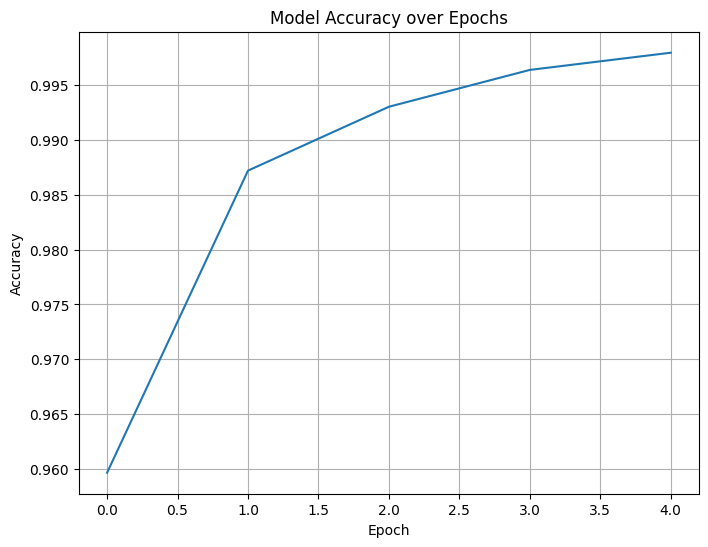

In [21]:
import matplotlib.pyplot as plt

# Get the accuracy history from the training
accuracy_history = history.history['accuracy']

# Plot the accuracy
plt.figure(figsize=(8, 6))
plt.plot(accuracy_history)
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()